In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# Load the data file using pandas
data = pd.read_csv(r"C:\Users\Azucar\Desktop\SharedMicromobilityProject\micromobility_choice.csv")
print(data.head())
# Check if there are missing values
nan_check = data.isna().any().any()
if nan_check:
    print("There are NaN values in the data file.")
else:
    print("There are no NaN values in the data file.")

   ID      slng       slat      elng       elat  duration  distance  \
0   0  8.496727  47.378521  8.490380  47.381591       194       587   
1   1  8.537729  47.379719  8.523722  47.389900      5754      1547   
2   2  8.510418  47.381356  8.523818  47.377148       442      1112   
3   3  8.535119  47.355189  8.536068  47.377502      1901      2482   
4   4  8.518982  47.386741  8.516692  47.389777       193       379   

   elevation_difference  temperature  windSpeed  day_week  hour_day  \
0                     0           10          7         0        22   
1                     3            0          4         1         6   
2                    -4            6          4         1        17   
3                    -3            7          9         1        13   
4                     3            5         24         0        11   

   restaurant  public facility  medical  accommodation  tourist attraction  \
0           0                1        0              0              

In [3]:
# Define the features (X) and target variable (y)
feature_cols = ["duration", "distance", "elevation_difference", "temperature", "windSpeed", 
                "day_week", "hour_day", "restaurant", "public facility", "medical", 
                "accommodation", "tourist attraction", "transportation", "education"]
X = data[feature_cols]
y = data["TripType"]
y.value_counts(normalize=True)

TripType
1    0.333333
2    0.333333
4    0.333333
Name: proportion, dtype: float64

In [4]:
### ---------------------------------Task 1---------------------------------------
# Splite the data into a training set and a testing set
# Use stratify=y to preserve the class distribution of the target variable in the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the random forest model: {accuracy:.2f}")

# Print the classification report
print(classification_report(y_test, y_pred
                           , target_names=["Bike", "E_bike", "E_scooter"]))

# Print the confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

Accuracy of the random forest model: 0.69
              precision    recall  f1-score   support

        Bike       0.60      0.67      0.63      1500
      E_bike       0.63      0.56      0.60      1500
   E_scooter       0.83      0.82      0.82      1500

    accuracy                           0.69      4500
   macro avg       0.69      0.69      0.68      4500
weighted avg       0.69      0.69      0.68      4500

[[1007  362  131]
 [ 527  847  126]
 [ 144  126 1230]]


In [5]:
### ---------------------------------Task 2---------------------------------------
# Define hyperparameter grid
param_grid = {
    "n_estimators": [100, 200, 300], # number of decision trees
    "max_depth": [None, 10, 20, 30], # maximum depth of each tree
    "min_samples_split": [2, 5, 10], # minimum number of samples required to split an internal node
    "min_samples_leaf": [1, 2, 4], # minimum number of samples requird at a leaf node
    "max_features": ["sqrt", "log2"] # ways to consider number of features when looking for the best split
}

# Define the RandomForestClassifier
rf_tuned = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced")

# Run GridSearchCV to test all parameter combinations with a 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_tuned, param_grid=param_grid, cv=5, 
                           scoring="f1_weighted",n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Print optimal model and parameters
print("Best hyperparameters:")
print(grid_search.best_params_)

best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best hyperparameters:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


In [6]:
# Predict on test dataset
y_pred_opt = best_rf.predict(X_test)

# Compute evaluation metrics
print("optimized model accuracy:", accuracy_score(y_test, y_pred_opt))
print(classification_report(y_test, y_pred_opt, target_names=["Bike", "E-bike", "E-scooter"]))

optimized model accuracy: 0.6915555555555556
              precision    recall  f1-score   support

        Bike       0.61      0.69      0.64      1500
      E-bike       0.65      0.57      0.60      1500
   E-scooter       0.82      0.82      0.82      1500

    accuracy                           0.69      4500
   macro avg       0.69      0.69      0.69      4500
weighted avg       0.69      0.69      0.69      4500



In [7]:
### ---------------------------------Task 3---------------------------------------
from sklearn.model_selection import cross_validate
# Define scoring metrics
scoring_metrics = {"accuracy": "accuracy",
                  "precision_macro": "precision_macro",
                  "recall_macro": "recall_macro",
                  "f1_macro": "f1_macro"}

# Conduct 5-fold cross validation on the entire dataset
cv = cross_validate(best_rf, X, y, cv=5, scoring=scoring_metrics, n_jobs=1, return_train_score=False)

# Calculate and print average metrics
print("Average 5-fold cross-validation results:")
for metric in scoring_metrics:
    mean_score = cv["test_" + metric].mean()
    print(f"{metric}:{mean_score:.2f}")

Average 5-fold cross-validation results:
accuracy:0.69
precision_macro:0.69
recall_macro:0.69
f1_macro:0.69


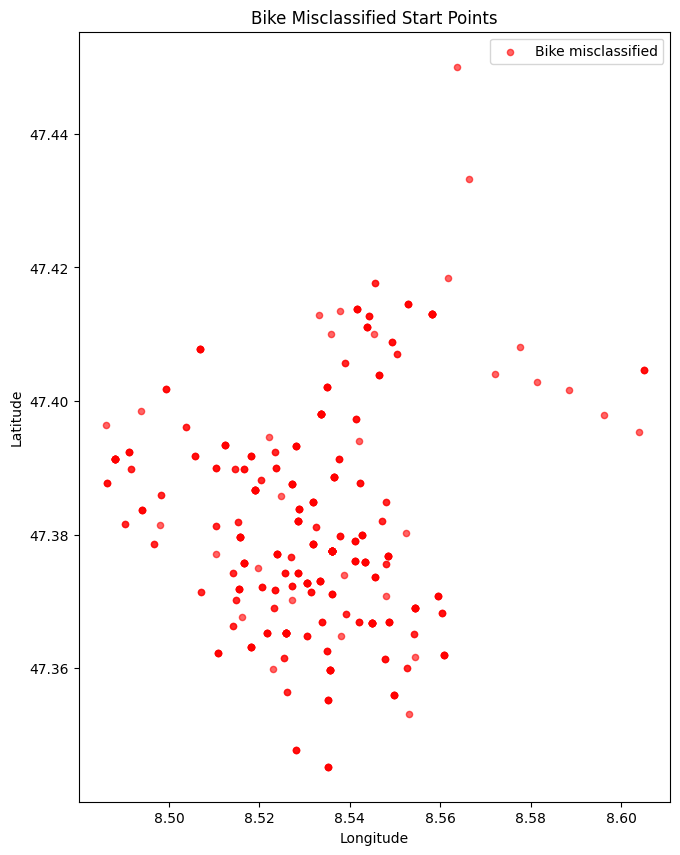

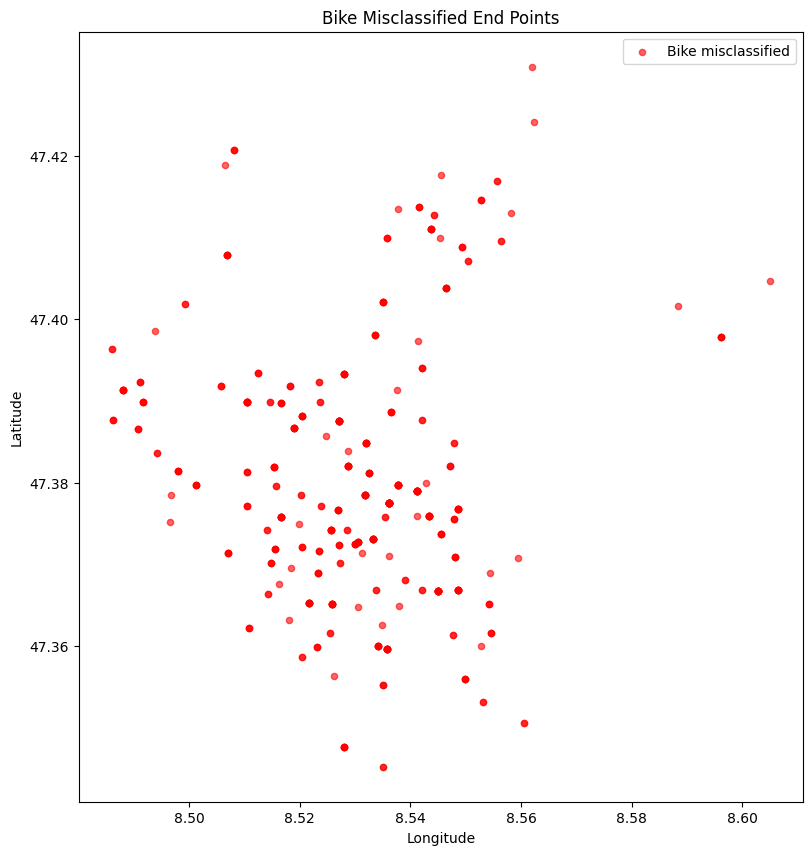

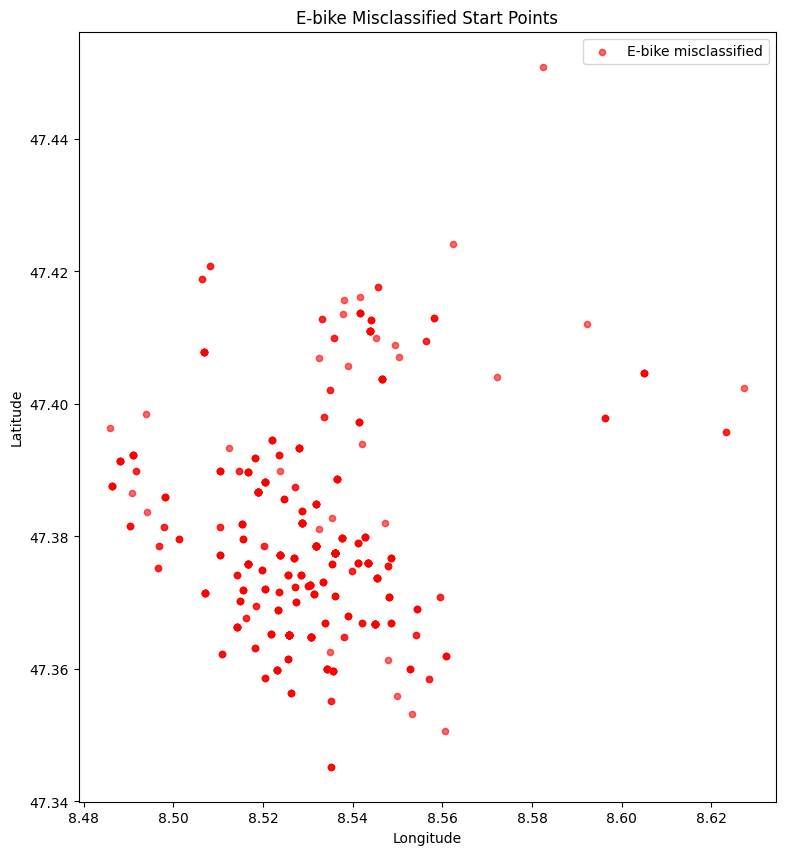

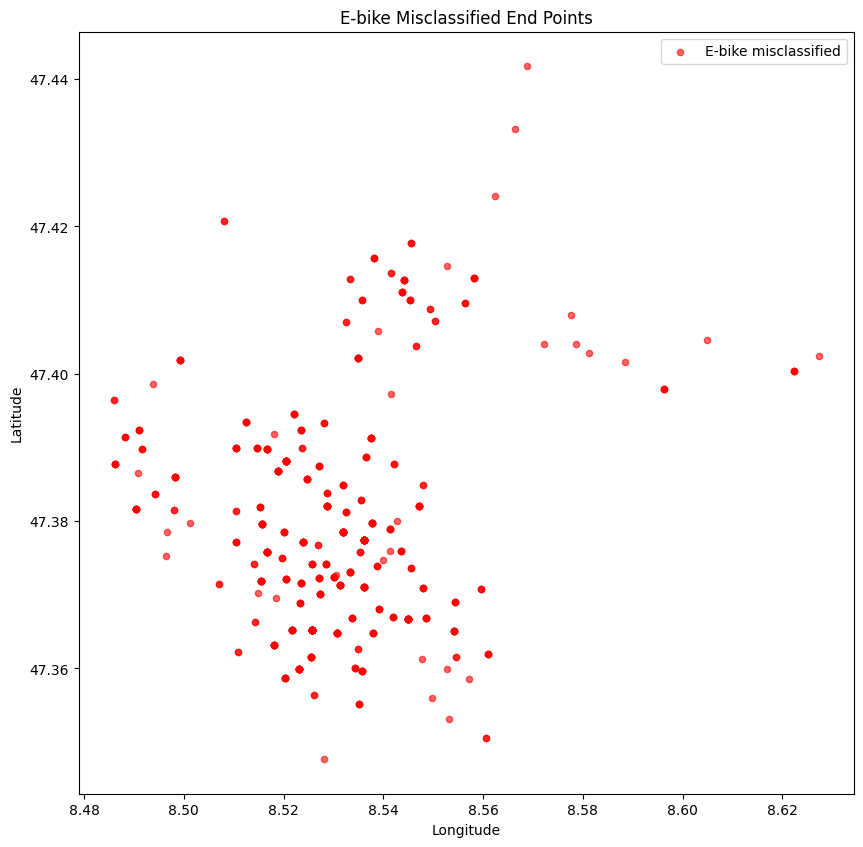

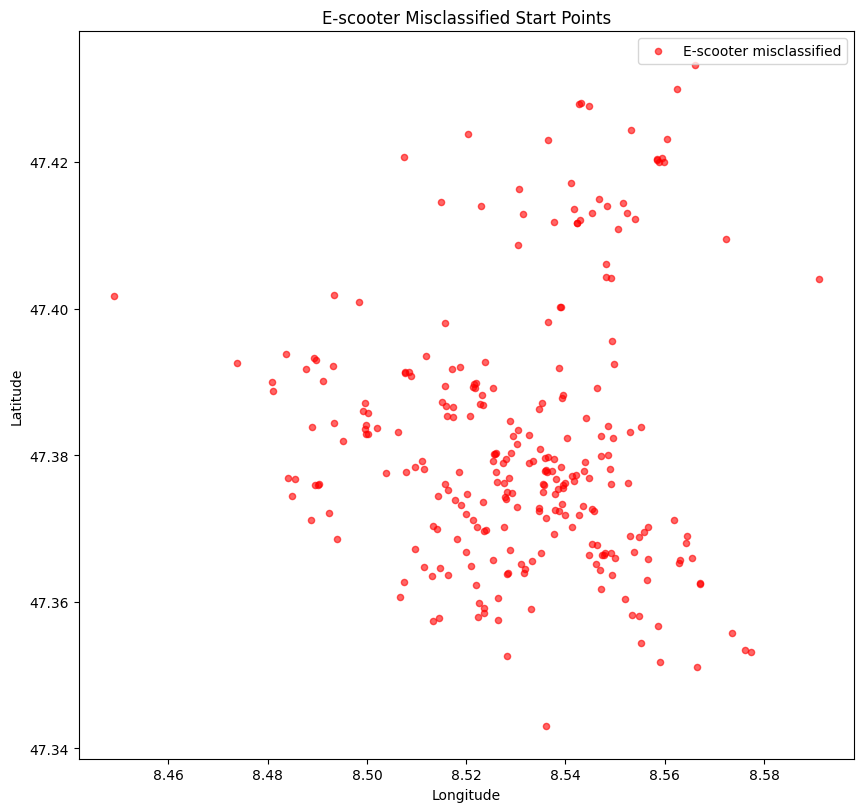

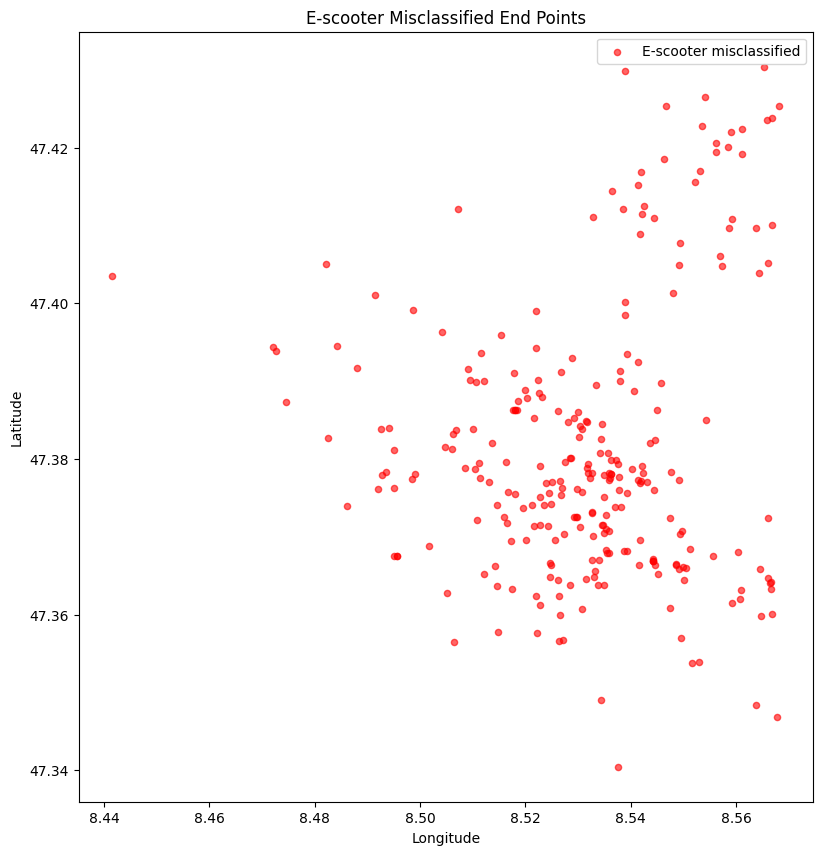

In [11]:
### ---------------------------------Task 4---------------------------------------
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Identify misclassified trips
y_pred_opt = best_rf.predict(X_test) # Create an array of predicted trip types
misclassified_idx = y_test[y_test != y_pred_opt].index # Find indices of misclassified trips
misclassified_data = data.loc[misclassified_idx] # Extract misclassified trips from the whole dataset through selecting rows by index

# Pair longitude and latitude of start points for each misclassified trip and create a list of point objects in the form of(longitude,latitude)
start_geometry = [Point(xy) for xy in zip(misclassified_data['slng'], misclassified_data['slat'])]

# Convert misclassified_data into a GeoDataFrame with the WGS84 coordinate reference system
gdf_start = gpd.GeoDataFrame(misclassified_data, geometry=start_geometry, crs="EPSG:4326")

# Pair longitude and latitude of end points for each misclassified trip and create a list of point objects in the form of(longitude,latitude)
end_geometry = [Point(xy) for xy in zip(misclassified_data['elng'], misclassified_data['elat'])]

# Convert misclassified_data into a GeoDataFrame with the WGS84 coordinate reference system
gdf_end = gpd.GeoDataFrame(misclassified_data, geometry=end_geometry, crs="EPSG:4326")

# Define mapping functions
def plot_misclassified(gdf, trip_type, point_type='Start'):
    trip_dict = {1:"Bike", 2:"E-bike", 4:"E-scooter"} # Associate numeric codes to names
    gdf_filtered = gdf[gdf['TripType'] == trip_type]
    if gdf_filtered.empty:
        print(f"No misclassified trips for {trip_dict[trip_type]}({point_type}points).")
        return
    
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(10,10))
    gdf_filtered.plot(ax=ax, color='red', markersize=20, alpha=0.6, label=f"{trip_dict[trip_type]} misclassified")
    
    # Add titles and labels
    ax.set_title(f"{trip_dict[trip_type]} Misclassified {point_type} Points")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    
    # Add legends and show the plot
    plt.legend()
    plt.show()
    
# Plot misclassified start and end points for each trip type
for trip_code in [1,2,4]:
    plot_misclassified(gdf_start, trip_code, point_type='Start')
    plot_misclassified(gdf_end, trip_code, point_type='End')


In [14]:
### Optional: Export the misclassified points into shapefiles ###
import os
import geopandas as gpd
from shapely.geometry import Point

# Identify misclassified trips
y_pred_opt = best_rf.predict(X_test)
misclassified_idx = y_test[y_test != y_pred_opt].index
misclassified_data = data.loc[misclassified_idx]

# Pair longitude and latitude of start points for each misclassified trip and create a list of point objects in the form of(longitude,latitude)
start_geometry = [Point(xy) for xy in zip(misclassified_data['slng'], misclassified_data['slat'])]

# Convert misclassified_data into a GeoDataFrame with the WGS84 coordinate reference system
gdf_start = gpd.GeoDataFrame(misclassified_data, geometry=start_geometry, crs="EPSG:4326")

# Pair longitude and latitude of end points for each misclassified trip and create a list of point objects in the form of(longitude,latitude)
end_geometry = [Point(xy) for xy in zip(misclassified_data['elng'], misclassified_data['elat'])]

# Convert misclassified_data into a GeoDataFrame with the WGS84 coordinate reference system
gdf_end = gpd.GeoDataFrame(misclassified_data, geometry=end_geometry, crs="EPSG:4326")

# Define output directory
output_dir = r"C:\Users\Azucar\Desktop\SharedMicromobilityProject\Misclassified_Start_End"
os.makedirs(output_dir, exist_ok = True)

# Loop through modes and export shapefiles
trip_types = {1:"Bike", 2:"E-Bike", 4:"E-scooter"}
for trip_code, trip_name in trip_types.items():
    gdf_start_mode = gdf_start[gdf_start['TripType'] == trip_code]
    gdf_end_mode = gdf_end[gdf_end['TripType'] == trip_code]
    
    if not gdf_start_mode.empty:
        start_path = os.path.join(output_dir,
                                 f"{trip_name}_misclassified_start.shp")
        gdf_start_mode.to_file(start_path)
    
    if not gdf_end_mode.empty:
        end_path = os.path.join(output_dir,
                               f"{trip_name}_misclassified_end.shp")
        gdf_end_mode.to_file(end_path)
    
    print(f"{trip_name}: export completed")

C:\Users\Azucar\AppData\Local\Temp\ipykernel_38532\2000076686.py:35: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_start_mode.to_file(start_path)
C:\Users\Azucar\AppData\Local\Programs\Python\Python39\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'elevation_difference' to 'elevation_'
  ogr_write(
C:\Users\Azucar\AppData\Local\Programs\Python\Python39\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'temperature' to 'temperatur'
  ogr_write(
C:\Users\Azucar\AppData\Local\Programs\Python\Python39\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'public facility' to 'public fac'
  ogr_write(
C:\Users\Azucar\AppData\Local\Programs\Python\Python39\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'accommodation' to 'accommodat'
  ogr_write(
C:\Users\Azucar\AppData\Local\Programs\

Bike: export completed
E-Bike: export completed
E-scooter: export completed


C:\Users\Azucar\AppData\Local\Temp\ipykernel_38532\2000076686.py:40: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_end_mode.to_file(end_path)
C:\Users\Azucar\AppData\Local\Programs\Python\Python39\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'elevation_difference' to 'elevation_'
  ogr_write(
C:\Users\Azucar\AppData\Local\Programs\Python\Python39\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'temperature' to 'temperatur'
  ogr_write(
C:\Users\Azucar\AppData\Local\Programs\Python\Python39\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'public facility' to 'public fac'
  ogr_write(
C:\Users\Azucar\AppData\Local\Programs\Python\Python39\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'accommodation' to 'accommodat'
  ogr_write(
C:\Users\Azucar\AppData\Local\Programs\Pyth